In [2]:
import requests
import json
import time
import pandas as pd
from pandas.io.json import json_normalize
import folium
import numpy as np

def coordinate(way):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"[out:json];way({way});node(w);out;"
    try:
        response = requests.get(overpass_url, params={'data': overpass_query})
        response = response.json()
        flat=flon=count=0
        for i in (response['elements']):
            flat+=i['lat']
            flon+=i['lon']
            count+=1
        1/count
    except:
        print("Error",way)
        return (None, None)
    return (flat/count, flon/count)

def boundary(county):
    boundaryset = []
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"[out:json];rel({county});out;"
    try:
        response = requests.get(overpass_url, params={'data': overpass_query})
        response = response.json()
        for i in (response['elements'][0]['members']):
            if(i['type']=='way' and i['role']=='outer'):
                coord = coordinate(i['ref'])
                if(coord[0]):
                    boundaryset.append(coord)
            time.sleep(1)
    except:
        print("Error", county)
        return None
    return boundaryset

def polystring(boundarylist):
    string = ""
    for i in boundarylist:
        string+=str(i[0]) + " "
        string+=str(i[1]) + " "
    return string[:-1]

#dfreduce method
'''
Input a dataframe and a settting and it outputs a reduced version of the dataframe
settings:
0 = node
1 = way 
2 = relation

'''
def dfreduce(df,setting):
    if(setting==0):
        required_columns = ["type", "id", "lat", "lon", "tags.name", "tags.amenity",
                        "tags.place", "tags.natural", "tags.landuse", "tags.brand","tags.shop","tags.building",
                           "tags.healthcare"]
        for col in required_columns:
            if col not in df:
                df[col] = None
        return df[required_columns]
    elif(setting==1):
        required_columns = ["type","id", "nodes", "tags.name", "tags.highway", "tags.tiger:name_base",
                            "tags.tiger:name_type", "tags.NHD:FTYPE", "tags.natural", "tags.waterway", 
                            "tags.landuse", "tags.addr:county", "tags.brand", "tags.shop", "tags.historic", 
                            "tags.leisure", "tags.building","tags.amenity","tags.man_made","tags.healthcare"]
        for col in required_columns:
            if col not in df:
                df[col] = None
        return df[required_columns]
    elif(setting==2):
        required_columns = ["type","id", "members", "tags.name", "tags.boundary",
                            "tags.leisure", "tags.landuse", "tags.route", "tags.place"]
        for col in required_columns:
            if col not in df:
                df[col] = None
        return df[required_columns]
    else:
        print("Invalid Setting")
        return None      
 
#boundarydata method:
'''
Input a boundarylist, a list of list of latitudes and longitudes, e.g. 
[[33.930124, -84.737658], [33.969074, -84.698486], [33.950073, -84.665274]]
and then pick a setting, to get all nodes, relations, or ways in that boundary
outputted as a dataframe.

Nodes = 0
Ways = 1
Relations = 2
'''   
    
def boundarydata(boundarylist,setting):
    boundarystring = polystring(boundarylist)
    overpass_url = "http://overpass-api.de/api/interpreter"
    if(setting==0):
        overpass_query = f"[out:json];node(poly:'{boundarystring}');out;"
        print(overpass_query)
    elif(setting==1):
        overpass_query = f"[out:json];way(poly:'{boundarystring}');out;"
        print(overpass_query)
    elif(setting==2):
        overpass_query = f"[out:json];relation['name'](poly:'{boundarystring}');out;"
        print(overpass_query)
    else:
        print("Invalid Setting")
        return None
    try:
        response = requests.get(overpass_url, params={'data': overpass_query})
        response = response.json()
        df = pd.json_normalize(response['elements'])
    except Exception as e:
        print(e)
        return None
    return df  
def mapcoordinate(coordinates):
    lattot = 0
    longtot = 0
    numcoord = len(coordinates)
    for i in coordinates:
        lattot += i[0]
        longtot += i[1]
    m = folium.Map(location=[lattot/numcoord, longtot/numcoord], zoom_start=12)
    for coord in coordinates:
        folium.Marker(coord).add_to(m)
    m.save('map.html')
    print("Ran Successfully")
    
#cleaneddata method
'''
Input a boundary and this method will output a cleaned dataframe of the nodes, ways, and relations from
that boundary with latitudes and longitudes and appropriate other metadata
'''
def cleaneddata(boundary):
    print(time.time())
    way_init = boundarydata(boundary, 1)
    ways = dfreduce(way_init, 1).copy()
    print(time.time())
    ways.loc[:, 'lat'] = None
    ways.loc[:, 'lon'] = None
    node_init = boundarydata(boundary, 0)
    nodes = dfreduce(node_init, 0).copy()
    print(time.time())
    ways['lat'] = ways['nodes'].apply(lambda node_list: nodes[nodes['id'].isin(node_list)]['lat'].mean())
    ways['lon'] = ways['nodes'].apply(lambda node_list: nodes[nodes['id'].isin(node_list)]['lon'].mean())
    '''
    for index, row in ways.iterrows():
        lat = lon = count = 0
        for i in row["nodes"]:
            location = nodes.loc[nodes['id'] == i, ['lat', 'lon']]
            if not location.empty:
                lat += location.iloc[0]['lat']
                lon += location.iloc[0]['lon']
                count += 1
        if count > 0:
            ways.at[index, 'lat'] = lat / count
            ways.at[index, 'lon'] = lon / count
    '''
    relation_init = boundarydata(boundary, 2)
    relations = dfreduce(relation_init, 2).copy()
    print(time.time())
    for index, row in relations.iterrows():
        lat = lon = count = 0
        for i in row["members"]:
            if(i['type']=='node'):
                location = nodes.loc[nodes['id'] == i['ref'], ['lat', 'lon']]
            elif(i['type']=='way'):
                location = ways.loc[ways['id'] == i['ref'], ['lat', 'lon']]
            if not location.empty:
                lat += location.iloc[0]['lat']
                lon += location.iloc[0]['lon']
                count += 1
        if count > 0:
            relations.at[index, 'lat'] = lat / count
            relations.at[index, 'lon'] = lon / count
    if 'lat' not in relations.columns:
        relations['lat'] = np.nan
    if 'lon' not in relations.columns:
        relations['lon'] = np.nan
    namedways = (ways[~(ways['tags.name'].isna() | ways['lat'].isna())])
    namedways.drop('nodes', axis=1, inplace=True)
    namednodes = (nodes[~(nodes['tags.name'].isna() | nodes['lat'].isna())])
    namedrelations = (relations[~(relations['tags.name'].isna() | relations['lat'].isna())])
    namedrelations.drop('members', axis=1, inplace=True)
    print(time.time())
    return namednodes, namedways, namedrelations

def categorizedf(df):
    required_columns = ['members', 'tags.tiger:name_type', 'tags.waterway', 'tags.leisure', 
                        'tags.landuse', 'tags.NHD:FTYPE', 'tags.natural', 'tags.tiger:name_base', 
                        'tags.man_made', 'tags.building', 'type', 'tags.name', 'tags.shop', 'tags.brand', 
                        'id', 'tags.place', 'nodes', 'tags.addr:county', 'lat', 'tags.amenity', 'tags.boundary', 
                        'tags.highway', 'tags.route', 'lon', 'tags.historic','tags.healthcare']
    for col in required_columns:
            if col not in df:
                df[col] = None
    columns = ["Name", "X", "Y", "Label"]
    final = pd.DataFrame(columns=columns)
    label = None
    for index, row in df.iterrows():
        if(row["tags.amenity"] in ["bar","biergarten","cafe","fast_food","food_court","ice_cream","pub",
        "restaurant", "baking_oven", "internet_cafe","kitchen"] or row["tags.building"] in ["bakehouse"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 0}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.amenity"] in ["college","dancing_school","driving_school","kindergarten","language_school","library", "surf_school"
                "toy_library","research_institute","training","music_school","school","traffic park","university"] or
                row["tags.building"] in ["college","kindergarten","school","university"] or
                row["tags.landuse"] in ["education"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 1}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.amenity"] in ["bicycle_parking","bicycle_repair_station","bicycle_rental","boat_rental","boat_sharing",
            "bus_station","car_rental","car_sharing","car_wash","compressed_air","vehicle_inspection",
            "charging_station","driver_training","ferry_terminal","fuel","grit_bin","motorcycle_parking",
            "parking","parking_entrance","parking_space","taxi"] or row["tags.building"] in ["train_station","transportation"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 2}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.amenity"] in ["atm","bank","bureau_de_change"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 3}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.amenity"] in ["baby_hatch","clinic","dentist","doctors","hospital","nursing_home",
            "pharmacy","social_facility","veterinary", "childcare"] or row["tags.building"] in ["hospital"]
              or type(row["tags.healthcare"])==str):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 4}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.amenity"] in ["brothel","casino","gambling","love_hotel","nightclub","stripclub","swingerclub"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 5}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.amenity"] in ["arts_centre","cinema","community_centre","conference_centre","events_venue","exhibition_centre",
            "fountain","music_venue","planetarium","public_bookcase","social_centre","studio","theatre"] or row["tags.building"]
              in ["civic","museum","grandstand","pavilion","riding_hall","sports_hall","stadium"] or type(row["tags.leisure"])==str
              or row["tags.landuse"] in ["fairground","recreation_ground","winter_sports"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 6}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.amenity"] in ["courthouse","fire_station","police","prison"] or row["tags.building"] in
           ["fire_station","military"] or row["tags.landuse"] in ["military"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 7}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.amenity"] in ["post_box","post_depot","post_office","ranger_station","townhall"] or 
          row["tags.building"] in ["government","public"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 8}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.amenity"] in ["animal_boarding","animal_breeding","animal_shelter","animal_training", "clock", "crematorium", "dive_centre",
            "funeral_hall","grave_yard","hunting_stand","kneipp_water_cure","lounger","photo_booth","place_of_mourning",
            "public_bath","refugee_site","vending_machine"] or row["tags.building"] in ["bridge","gatehouse","toilets","hangar","hut",
            "shed","carport","garage","garages","parking","digester","service","transformer_tower","water_tower",
            "storage_tank","silo","construction","container","roof","ruins","yes"] or type(row["tags.man_made"])==str or
              row["tags.landuse"] in ["brownfield","cemetery","conservation","greenfield","landfill","village_green"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 9}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.amenity"] in ["monastery","place_of_worship"] or row["tags.building"] in ["cathedral","chapel","church","kingdom_hall",
            "monastery","mosque","presbytery","religious","shrine","synagogue","temple"] or row["tags.landuse"] in ["religious"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 10}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(type(row["tags.highway"])==str):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 11}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.building"] in ["bungalow","cabin","detached","farm","ger","house","houseboat","residential",
            "static_caravan", "stilt_house","beach_hut","tent"] or row["tags.landuse"] in ["residential"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 12}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.building"] in ["apartments","barracks","dormitory","hotel","semidetached_house","terrace","bunker"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 13}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.building"] in ["castle","tower"] or type(row["tags.historic"])==str or row["tags.boundary"] in ["marker"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 14}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.landuse"] in ["forest","meadow","orchard","grass"] or (type(row["tags.natural"])==str and row["tags.natural"]
            not in ["bay","beach","blowhole","cape","coastline","crevasse","geyser","glacier","hot_spring", "isthmus","mud","reef",
            "shoal","spring","strait","water","wetland"]) or row["tags.boundary"] in ["forest","forest_compartment","national_park","protected_area"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 15}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.landuse"] in ["basin","reservoir","salt_pond"] or type(row["tags.waterway"])==str or row["tags.natural"]
           in ["bay","beach","blowhole","cape","coastline","crevasse","geyser","glacier","hot_spring","isthmus","mud",
            "reef","shoal","spring","strait","water","wetland"] or type(row["tags.NHD:FTYPE"])==str):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 16}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(type(row["tags.route"])==str):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 17}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.place"] in ["neighbourhood", "city_block","plot","farm"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 18}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue
        if(row["tags.amenity"] in ["marketplace"] or row["tags.building"] in ["commercial","industrial","kiosk","office","retail",
            "supermarket","warehouse","barn","conservatory","cowshed","farm_auxiliary","greenhouse","slurry_tank","stable","sty","livestock"]
              or type(row["tags.shop"])==str or type(row["tags.brand"])==str or row["tags.landuse"] in ["commercial", "construction","industrial","retail","institutional",
            "aquaculture","allotments","farmland","farmyard","paddy","animal_keeping","greenhouse_horticulture",
            "plant_nursery","vineyard","depot","garages","port","quarry","railway"]):
            new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 19}
            new_row_df = pd.DataFrame([new_row_data], columns=columns)
            final = pd.concat([final, new_row_df], ignore_index=True)
            continue      
        new_row_data = {"Name": row["tags.name"],"X": row["lat"],"Y": row["lon"],"Label": 20}
        new_row_df = pd.DataFrame([new_row_data], columns=columns)
        final = pd.concat([final, new_row_df], ignore_index=True)
    print(time.time())
    return final
def fullycleanedf(boundary):
    n, w, r = cleaneddata(boundary)
    clean_n = categorizedf(n)
    clean_w = categorizedf(w)
    clean_r = categorizedf(r)
    cleaned_df = pd.concat([clean_n, clean_w, clean_r], ignore_index=True)
    print(time.time())
    return cleaned_df
#mapcoordinate([[33.930124, -84.737658], [33.969074, -84.698486], [33.950073, -84.665274]])
#print(boundarydata([[33.930124, -84.737658], [33.969074, -84.698486], [33.950073, -84.665274]],2))
#print(coordinate(9137889))
#type(coordinate(9137889))
#x = boundary(1020125)
#print(jsontodf("LostMountain"))
#Lost Mountain: [[33.930124, -84.737658], [33.969074, -84.698486], [33.950073, -84.665274]]
#Upper Alabama: [[34.971507, -86.156501],[34.877694, -86.093169],[34.884261, -86.234892]]
#Sutallee: [[34.246059, -84.635691],[34.191233, -84.654002],[34.216392, -84.603647]]
#Acwoth: [[34.063968, -84.703106],[34.081080, -84.678814],[34.056670, -84.659844]]
#TopLeftCobb: [[33.947153, -84.739508],[33.949712, -84.646773],[33.949712,-84.647547],[33.947153, -84.647547]]
#CobbRectangle: [[34.078992, -84.737692],[33.746060, -84.741341],[]

In [22]:
p = time.time()
Lowertri = fullycleanedf([[33.803751, -84.622982],[33.745533, -84.576977],[33.804322, -84.500072]])
FirstRect = fullycleanedf([[33.80722, -84.724386], [33.80722, -84.45387], [33.859458, -84.45387], [33.859458, -84.724386]])
SecondRect = fullycleanedf([[33.859458, -84.724386], [33.859458, -84.440893], [33.904208, -84.440893], [33.904208, -84.724386]])
ThirdRect = fullycleanedf([[33.904208, -84.723666], [33.904208, -84.403741], [33.947531, -84.403741], [33.947531, -84.723666]])
FifthRect = fullycleanedf([[33.947557, -84.739562], [33.947557, -84.37455], [33.991414, -84.37455], [33.991414, -84.739562]])
SixthRect = fullycleanedf([[33.991414, -84.739562], [33.991414, -84.37455], [34.035271, -84.37455], [34.035271, -84.739562]])
SeventhRect = fullycleanedf([[34.035271, -84.739562], [34.035271, -84.37455], [34.079128, -84.37455], [34.079128, -84.739562]])
cleaned_df = pd.concat([Lowertri, FirstRect,SecondRect,ThirdRect,FifthRect,SixthRect,SeventhRect], ignore_index=True)
file_path4 = 'CleanedDataCobb.csv'
cleaned_df.to_csv(file_path4, index=False)
print(time.time()-p)
#Runtime: 27 minutes

1695357628.0456262
[out:json];way(poly:'33.803751 -84.622982 33.745533 -84.576977 33.804322 -84.500072');out;
1695357630.565086
[out:json];node(poly:'33.803751 -84.622982 33.745533 -84.576977 33.804322 -84.500072');out;
1695357632.1890519
[out:json];relation['name'](poly:'33.803751 -84.622982 33.745533 -84.576977 33.804322 -84.500072');out;
1695357647.521225


/var/folders/zr/qxdch5rn2cg6_jm29j9f1lzm0000gn/T/ipykernel_16058/3825639774.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  namedways.drop('nodes', axis=1, inplace=True)


1695357648.4661381
1695357648.5215309
1695357648.714161
1695357648.720969
1695357648.721086
1695357648.721266
[out:json];way(poly:'33.859458 -84.724386 33.80722 -84.724386 33.859458 -84.45387 33.80722 -84.45387');out;
1695357650.895571
[out:json];node(poly:'33.859458 -84.724386 33.80722 -84.724386 33.859458 -84.45387 33.80722 -84.45387');out;
1695357653.978946
[out:json];relation['name'](poly:'33.859458 -84.724386 33.80722 -84.724386 33.859458 -84.45387 33.80722 -84.45387');out;
1695357698.6230478


/var/folders/zr/qxdch5rn2cg6_jm29j9f1lzm0000gn/T/ipykernel_16058/3825639774.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  namedways.drop('nodes', axis=1, inplace=True)


1695357700.2371871
1695357700.4082189
1695357700.8427038
1695357700.8520582
1695357700.8521678
1695357700.852706
[out:json];way(poly:'33.859458 -84.724386 33.904208 -84.724386 33.859458 -84.440893 33.904208 -84.440893');out;
1695357703.991331
[out:json];node(poly:'33.859458 -84.724386 33.904208 -84.724386 33.859458 -84.440893 33.904208 -84.440893');out;
1695357710.521688
[out:json];relation['name'](poly:'33.859458 -84.724386 33.904208 -84.724386 33.859458 -84.440893 33.904208 -84.440893');out;
1695357783.113493


/var/folders/zr/qxdch5rn2cg6_jm29j9f1lzm0000gn/T/ipykernel_16058/3825639774.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  namedways.drop('nodes', axis=1, inplace=True)


1695357786.239464
1695357786.671772
1695357787.382849
1695357787.40357
1695357787.403695
1695357787.4047308
[out:json];way(poly:'33.943697 -84.403741 33.947531 -84.723666 33.904208 -84.403741 33.904208 -84.723666');out;
1695357789.8390641
[out:json];node(poly:'33.943697 -84.403741 33.947531 -84.723666 33.904208 -84.403741 33.904208 -84.723666');out;
1695357793.3560572
[out:json];relation['name'](poly:'33.943697 -84.403741 33.947531 -84.723666 33.904208 -84.403741 33.904208 -84.723666');out;
1695357839.744364


/var/folders/zr/qxdch5rn2cg6_jm29j9f1lzm0000gn/T/ipykernel_16058/3825639774.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  namedways.drop('nodes', axis=1, inplace=True)


1695357842.437105
1695357842.680453
1695357843.284019
1695357843.300001
1695357843.3001118
1695357843.30075
[out:json];way(poly:'33.947557 -84.739562 33.947557 -84.37455 33.991414 -84.37455 33.991414 -84.739562');out;
1695357847.942079
[out:json];node(poly:'33.947557 -84.739562 33.947557 -84.37455 33.991414 -84.37455 33.991414 -84.739562');out;
1695357862.1993432
[out:json];relation['name'](poly:'33.947557 -84.739562 33.947557 -84.37455 33.991414 -84.37455 33.991414 -84.739562');out;
1695358110.650532


/var/folders/zr/qxdch5rn2cg6_jm29j9f1lzm0000gn/T/ipykernel_16058/3825639774.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  namedways.drop('nodes', axis=1, inplace=True)


1695358113.069995
1695358113.779765
1695358114.997296
1695358115.016098
1695358115.0162299
1695358115.0174348
[out:json];way(poly:'33.991414 -84.739562 33.991414 -84.37455 34.035271 -84.37455 34.035271 -84.739562');out;
1695358118.71311
[out:json];node(poly:'33.991414 -84.739562 33.991414 -84.37455 34.035271 -84.37455 34.035271 -84.739562');out;
1695358134.466205
[out:json];relation['name'](poly:'33.991414 -84.739562 33.991414 -84.37455 34.035271 -84.37455 34.035271 -84.739562');out;
1695358454.052646


/var/folders/zr/qxdch5rn2cg6_jm29j9f1lzm0000gn/T/ipykernel_16058/3825639774.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  namedways.drop('nodes', axis=1, inplace=True)


1695358456.338318
1695358457.041844
1695358458.384325
1695358458.400981
1695358458.401118
1695358458.402889
[out:json];way(poly:'34.035271 -84.739562 34.035271 -84.37455 34.079128 -84.37455 34.079128 -84.739562');out;
1695358461.929591
[out:json];node(poly:'34.035271 -84.739562 34.035271 -84.37455 34.079128 -84.37455 34.079128 -84.739562');out;
1695358474.666046
[out:json];relation['name'](poly:'34.035271 -84.739562 34.035271 -84.37455 34.079128 -84.37455 34.079128 -84.739562');out;
1695358812.254282


/var/folders/zr/qxdch5rn2cg6_jm29j9f1lzm0000gn/T/ipykernel_16058/3825639774.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  namedways.drop('nodes', axis=1, inplace=True)


1695358814.6098099
1695358815.282815
1695358816.484983
1695358816.498341
1695358816.4985201


NameError: name 'LowerTri' is not defined

In [0]:
'''
LowerTri: [[33.803751, -84.622982],[33.745533, -84.576977],[33.804322, -84.500072]]
FirstRect: [[33.859458, -84.724386],[33.807220, -84.724386],[33.859458, -84.453870], [33.807220, -84.453870]]
SecRect: [[33.859458, -84.724386],[33.904208,-84.724386], [33.859458, -84.440893],[33.904208, -84.440893]]
ThrRect: [[33.943697, -84.403741], [33.947531, -84.723666], [33.904208,-84.403741],[33.904208,-84.723666]]
FthRect: [[33.947557, -84.739562], [33.947557, -84.37455], [33.991414, -84.37455], [33.991414, -84.739562]]
SxthRect: [[33.991414, -84.739562], [33.991414, -84.37455], [34.035271, -84.37455], [34.035271, -84.739562]]
SvthRect: [[34.035271, -84.739562], [34.035271, -84.37455], [34.079128, -84.37455], [34.079128, -84.739562]]
'''

In [0]:
file_path1 = 'NamedNodes.csv'
x.to_csv(file_path1, index=False)
file_path2 = 'NamedWays.csv'
y.to_csv(file_path2, index=False)
file_path3 = 'NamedRelations.csv'
z.to_csv(file_path3, index=False)
file_path4 = 'LabeledWays.csv'
p.to_csv(file_path4, index=False)

In [0]:
'''
List of Categories:
Sustenance(Food): 0
Education: 1
Transportation: 2
Financial: 3
Healthcare: 4
Entertainment1: 5
Entertainment2: 6
PublicService1: 7
PublicService2: 8
Other: 9
Church: 10
Road: 11
Individual Building: 12
Group Building: 13
Complex Historic: 14
Nature: 15
Water: 16
Route: 17
Group Place: 18
Commercial + Agriculture: 19
Not categorized: 20
'''

In [26]:
mapcoordinate([[33.859458, -84.724386],[33.807220, -84.724386],[33.859458, -84.453870], [33.807220, -84.453870]])

Ran Successfully


In [23]:
cleaned_df = pd.concat([Lowertri, FirstRect,SecondRect,ThirdRect,FifthRect,SixthRect,SeventhRect], ignore_index=True)
file_path4 = 'CleanedDataCobb.csv'
cleaned_df.to_csv(file_path4, index=False)

In [27]:
print(FirstRect)
file_path4 = 'CleanedDataFirstRect.csv'
FirstRect.to_csv(file_path4, index=False)

                                           Name          X          Y Label
0                                  Nickajack DD  33.837842 -84.539720    20
1                                       Oakdale  33.818717 -84.497709    18
2                                     Pine Oaks  33.835661 -84.687435    18
3                             Deerbrook Estates  33.838439 -84.698824    18
4                                    Mann Manor  33.837883 -84.704380    18
...                                         ...        ...        ...   ...
2125    Silver Comet Trail Cumberland Connector  33.845473 -84.499372    17
2126                 Whetstone Creek PATH Trail  33.819917 -84.455361    17
2127  Colonial Pipeline | Atlanta -> Bainbridge  33.832127 -84.629838    17
2128           Atlanta Terminal Subdivision (A)  33.825014 -84.464219    17
2129  Colonial Pipeline - Atlanta -> Bainbridge  33.832127 -84.629838    17

[2130 rows x 4 columns]


In [28]:
print(polystring([[33.859458, -84.724386],[33.807220, -84.724386],[33.859458, -84.453870], [33.807220, -84.453870]]))

33.859458 -84.724386 33.80722 -84.724386 33.859458 -84.45387 33.80722 -84.45387


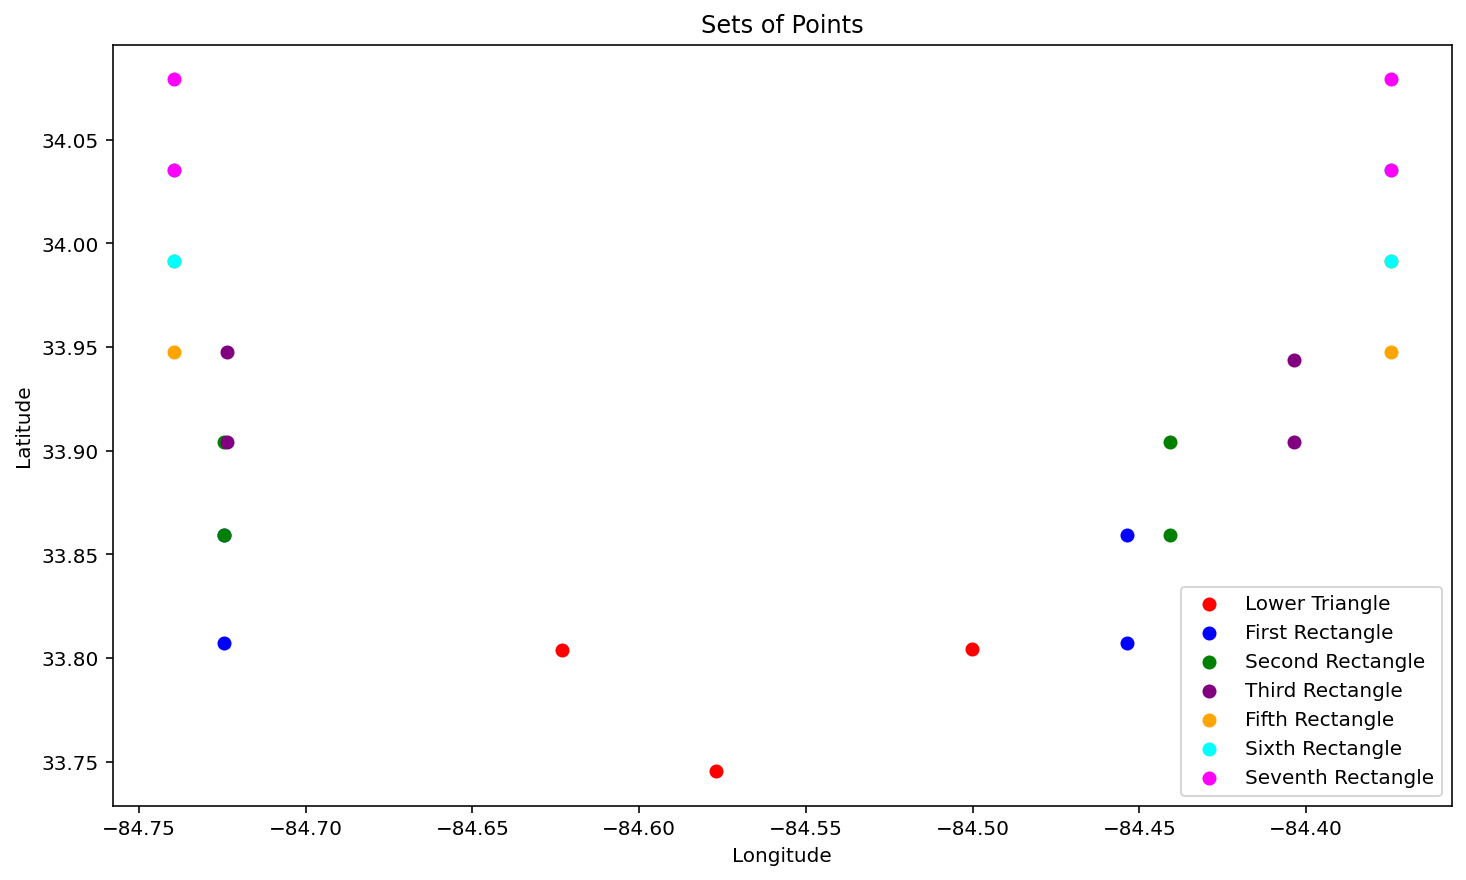

In [2]:
import matplotlib.pyplot as plt

# Function to extract coordinates from the given list of points
def extract_coordinates(points):
    return [point[1] for point in points], [point[0] for point in points]

# Data for different sets of points
lower_tri = [[33.803751, -84.622982],[33.745533, -84.576977],[33.804322, -84.500072]]
first_rect = [[33.859458, -84.724386],[33.807220, -84.724386],[33.859458, -84.453870], [33.807220, -84.453870]]
second_rect = [[33.859458, -84.724386],[33.904208,-84.724386], [33.859458, -84.440893],[33.904208, -84.440893]]
third_rect = [[33.943697, -84.403741], [33.947531, -84.723666], [33.904208,-84.403741],[33.904208,-84.723666]]
fifth_rect = [[33.947557, -84.739562], [33.947557, -84.37455], [33.991414, -84.37455], [33.991414, -84.739562]]
sixth_rect = [[33.991414, -84.739562], [33.991414, -84.37455], [34.035271, -84.37455], [34.035271, -84.739562]]
seventh_rect = [[34.035271, -84.739562], [34.035271, -84.37455], [34.079128, -84.37455], [34.079128, -84.739562]]

# Extract coordinates for plotting
x_lower_tri, y_lower_tri = extract_coordinates(lower_tri)
x_first_rect, y_first_rect = extract_coordinates(first_rect)
x_second_rect, y_second_rect = extract_coordinates(second_rect)
x_third_rect, y_third_rect = extract_coordinates(third_rect)
x_fifth_rect, y_fifth_rect = extract_coordinates(fifth_rect)
x_sixth_rect, y_sixth_rect = extract_coordinates(sixth_rect)
x_seventh_rect, y_seventh_rect = extract_coordinates(seventh_rect)

# Plotting the points with different colors
plt.scatter(x_lower_tri, y_lower_tri, color='red', label='Lower Triangle')
plt.scatter(x_first_rect, y_first_rect, color='blue', label='First Rectangle')
plt.scatter(x_second_rect, y_second_rect, color='green', label='Second Rectangle')
plt.scatter(x_third_rect, y_third_rect, color='purple', label='Third Rectangle')
plt.scatter(x_fifth_rect, y_fifth_rect, color='orange', label='Fifth Rectangle')
plt.scatter(x_sixth_rect, y_sixth_rect, color='cyan', label='Sixth Rectangle')
plt.scatter(x_seventh_rect, y_seventh_rect, color='magenta', label='Seventh Rectangle')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sets of Points')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [3]:
def makepoly(x):
    minlat, minlon = float('inf'), float('inf')
    maxlat, maxlon = -float('inf'),-float('inf')
    for i in x:
        minlat = min(minlat,i[0])
        maxlat = max(maxlat,i[0])
        minlon = min(minlon,i[1])
        maxlon = max(maxlon,i[1])
    return [[minlat,minlon],[minlat,maxlon],[maxlat,maxlon],[maxlat,minlon]]

p = makepoly([[34.035271, -84.739562], [34.035271, -84.37455], [34.079128, -84.37455], [34.079128, -84.739562]])
def polystring(boundarylist):
    string = ""
    for i in boundarylist:
        string+=str(i[0]) + " "
        string+=str(i[1]) + " "
    return string[:-1]

print(p)
print(polystring(p))

[[34.035271, -84.739562], [34.035271, -84.37455], [34.079128, -84.37455], [34.079128, -84.739562]]
34.035271 -84.739562 34.035271 -84.37455 34.079128 -84.37455 34.079128 -84.739562
